# Task 2: News Category Classification (Multiclass)

## Overview
This notebook implements a comprehensive news article classification system using machine learning approaches. We'll build a multiclass classifier to categorize news articles into different topics using the **AG News Dataset**.

## Learning Objectives
- Apply text preprocessing techniques for multiclass classification
- Implement feature extraction using TF-IDF and Count Vectorization
- Build and compare multiple multiclass classification models
- Analyze feature importance and category-specific patterns
- Visualize results with word clouds and classification metrics

## Dataset
We'll use the AG News Dataset with 4 categories:
- **Class 1: World** (Politics/International)
- **Class 2: Sports** 
- **Class 3: Business**
- **Class 4: Technology/Science**

## Pipeline Overview
1. **Data Loading & Exploration**
2. **Text Preprocessing** (cleaning, tokenization, normalization)
3. **Feature Extraction** (TF-IDF, Count Vectorization)
4. **Model Training** (Logistic Regression, Random Forest, SVM, Neural Networks)
5. **Model Evaluation & Comparison**
6. **Category Analysis & Visualization**


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost (optional)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost is available!")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

# Import our custom utilities
import sys
sys.path.append('./utils')
from preprocessing import TextPreprocessor
from evaluation import evaluate_classification, plot_roc_curve, compare_models

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


XGBoost is available!
Libraries imported successfully!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\assem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading and Exploration

We'll load the real AG News dataset and explore its structure and characteristics.


In [2]:
# Load the AG News dataset
print("Loading AG News Dataset...")

# Load training and test data
train_df = pd.read_csv('../AG News Dataset/train.csv')
test_df = pd.read_csv('../AG News Dataset/test.csv')

print("✅ Successfully loaded AG News dataset!")

# Rename columns for clarity
train_df.columns = ['class_index', 'title', 'description']
test_df.columns = ['class_index', 'title', 'description']

# Create full text by combining title and description
train_df['text'] = train_df['title'].astype(str) + ' ' + train_df['description'].astype(str)
test_df['text'] = test_df['title'].astype(str) + ' ' + test_df['description'].astype(str)

# Create class labels (convert to 0-indexed)
train_df['label'] = train_df['class_index'] - 1
test_df['label'] = test_df['class_index'] - 1

# Define class names
class_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
train_df['category'] = train_df['label'].map(class_names)
test_df['category'] = test_df['label'].map(class_names)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")

print("\nFirst few rows:")
print(train_df[['title', 'description', 'category', 'label']].head())

print(f"\nClass distribution in training set:")
print(train_df['category'].value_counts())
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts())


Loading AG News Dataset...
✅ Successfully loaded AG News dataset!
Training set shape: (120000, 6)
Test set shape: (7600, 6)
Columns: ['class_index', 'title', 'description', 'text', 'label', 'category']

First few rows:
                                               title  \
0  Wall St. Bears Claw Back Into the Black (Reuters)   
1  Carlyle Looks Toward Commercial Aerospace (Reu...   
2    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Oil prices soar to all-time record, posing new...   

                                         description  category  label  
0  Reuters - Short-sellers, Wall Street's dwindli...  Business      2  
1  Reuters - Private investment firm Carlyle Grou...  Business      2  
2  Reuters - Soaring crude prices plus worries\ab...  Business      2  
3  Reuters - Authorities have halted oil export\f...  Business      2  
4  AFP - Tearaway world oil prices, toppling reco...  Business      2  

Class distr

Basic text statistics:
Average text length: 236.46 characters
Average word count: 37.84 words
Max text length: 1012 characters
Min text length: 17 characters

SAMPLE ARTICLES FROM EACH CATEGORY

WORLD (Class 1):
Title: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters)
Description: Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to ...
--------------------------------------------------

SPORTS (Class 2):
Title: Phelps, Thorpe Advance in 200 Freestyle (AP)
Description: AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final...
--------------------------------------------------

BUSINESS (Class 3):
Title: Wall St. Bears Claw Back Into the Black (Reuters)
Description: Reuters - Short-selle

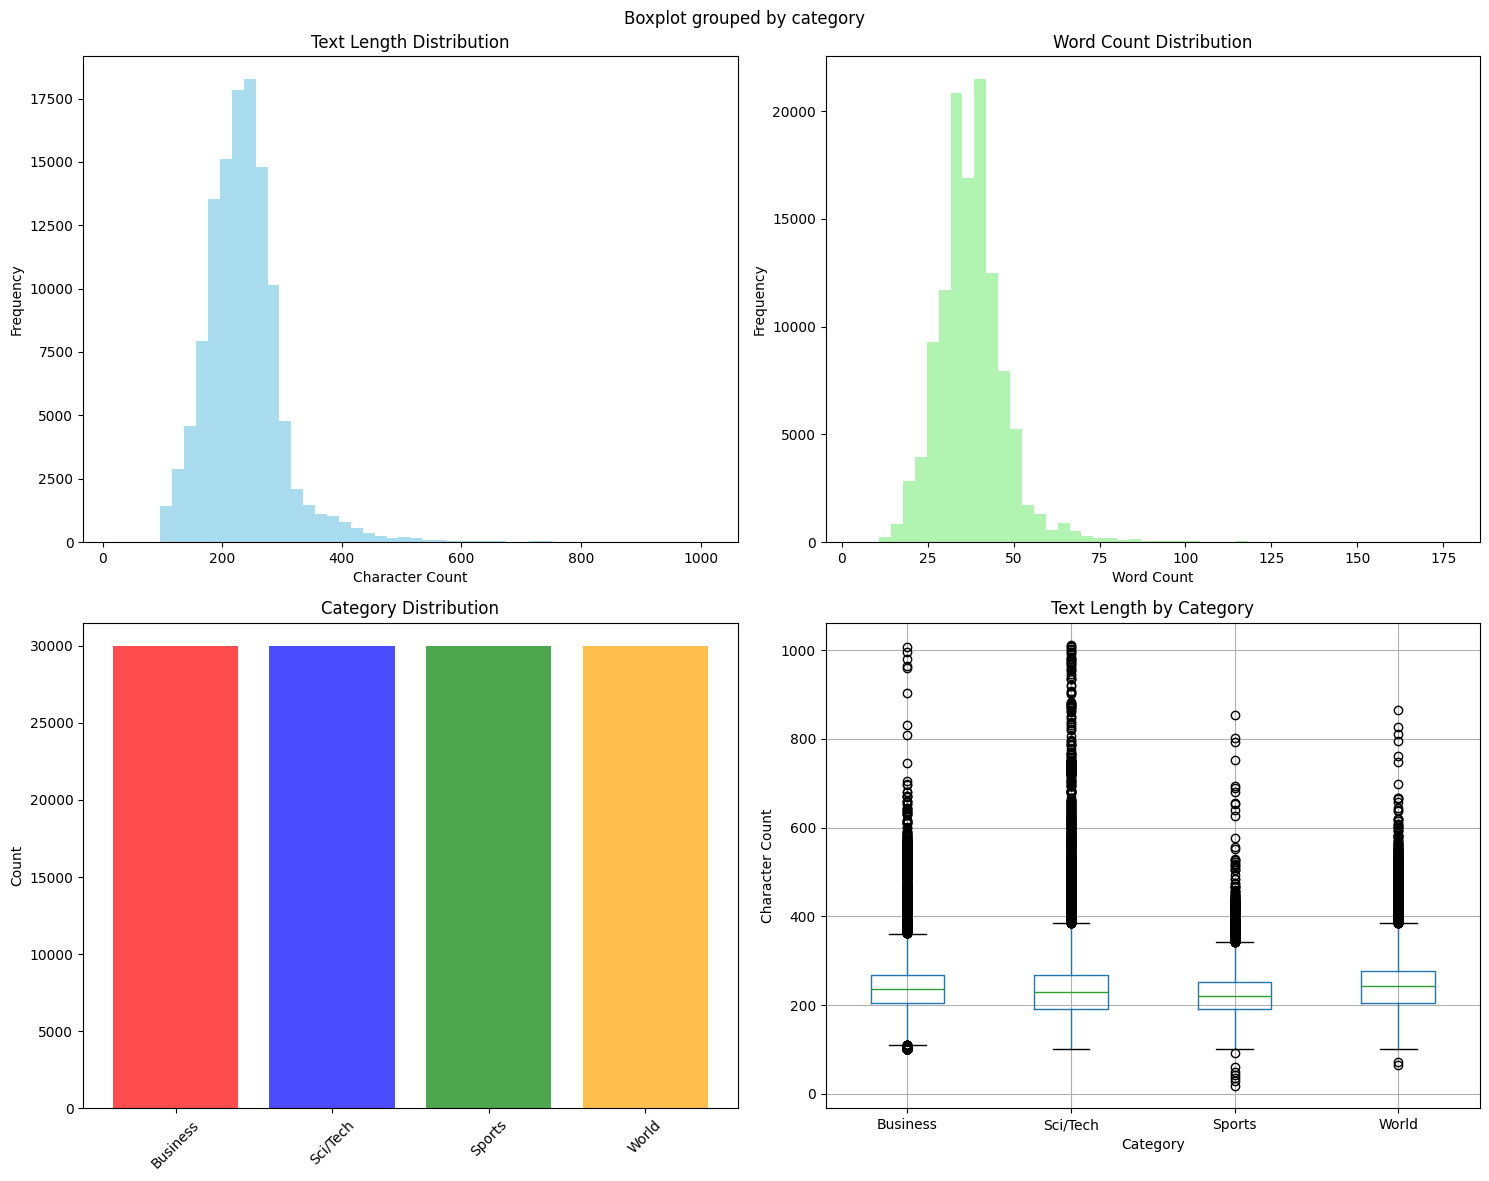


Class distribution percentages:
Business: 30000 (25.0%)
Sci/Tech: 30000 (25.0%)
Sports: 30000 (25.0%)
World: 30000 (25.0%)


In [3]:
# Basic text statistics and exploration
print("Basic text statistics:")
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

print(f"Average text length: {train_df['text_length'].mean():.2f} characters")
print(f"Average word count: {train_df['word_count'].mean():.2f} words")
print(f"Max text length: {train_df['text_length'].max()} characters")
print(f"Min text length: {train_df['text_length'].min()} characters")

# Show sample articles from each category
print("\n" + "="*80)
print("SAMPLE ARTICLES FROM EACH CATEGORY")
print("="*80)

for label, category in class_names.items():
    sample = train_df[train_df['label'] == label].iloc[0]
    print(f"\n{category.upper()} (Class {label+1}):")
    print(f"Title: {sample['title']}")
    print(f"Description: {sample['description'][:200]}...")
    print("-" * 50)

# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Text length distribution
axes[0, 0].hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')

# Word count distribution  
axes[0, 1].hist(train_df['word_count'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Category distribution
category_counts = train_df['category'].value_counts()
axes[1, 0].bar(category_counts.index, category_counts.values, color=['red', 'blue', 'green', 'orange'], alpha=0.7)
axes[1, 0].set_title('Category Distribution')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Text length by category
train_df.boxplot(column='text_length', by='category', ax=axes[1, 1])
axes[1, 1].set_title('Text Length by Category')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Character Count')

plt.tight_layout()
plt.show()

print(f"\nClass distribution percentages:")
for category, count in category_counts.items():
    percentage = count / len(train_df) * 100
    print(f"{category}: {count} ({percentage:.1f}%)")


## 2. Text Preprocessing

We'll apply comprehensive text preprocessing using techniques from Lab 1, adapted for multiclass classification.


In [4]:
# Initialize text preprocessor for news articles
preprocessor = TextPreprocessor(
    remove_html=True,
    expand_contractions=True,
    to_lowercase=True,
    remove_punctuation=True,
    remove_numbers=True,
    remove_stopwords=True,
    lemmatize=True,
    min_length=2
)

print("Original text example:")
original_text = train_df['text'].iloc[0]
print(f"'{original_text[:300]}...'")

# Apply preprocessing to a sample first
processed_sample = preprocessor.preprocess_text(original_text)
print("\nProcessed text example:")
print(f"'{processed_sample[:300]}...'")

print(f"\nText reduction: {len(original_text)} -> {len(processed_sample)} characters ({((len(original_text) - len(processed_sample))/len(original_text)*100):.1f}% reduction)")

# For demonstration, let's work with a subset for faster processing
# You can increase sample_size or use the full dataset
sample_size = 20000  # Using 20k samples (5k per class)
print(f"\nWorking with {sample_size} articles for faster processing...")

# Sample the dataset while maintaining class balance
train_sample = train_df.groupby('label').apply(
    lambda x: x.sample(n=sample_size//4, random_state=42)
).reset_index(drop=True)

print(f"Sample class distribution:")
print(train_sample['category'].value_counts())


Original text example:
'Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....'

Processed text example:
'wall st bear claw back black reuters reuters short seller wall street dwindling band ultra cynic seeing green...'

Text reduction: 144 -> 109 characters (24.3% reduction)

Working with 20000 articles for faster processing...
Sample class distribution:
category
World       5000
Sports      5000
Business    5000
Sci/Tech    5000
Name: count, dtype: int64


In [5]:
# Apply preprocessing to the dataset
print("Applying text preprocessing to the dataset...")
print("This may take a few minutes...")

# Apply preprocessing in batches
train_sample['processed_text'] = train_sample['text'].apply(preprocessor.preprocess_text)

print("✅ Preprocessing completed!")

# Compare text lengths before and after preprocessing
print("\nText length comparison:")
original_lengths = train_sample['text'].str.len()
processed_lengths = train_sample['processed_text'].str.len()

print(f"Original - Mean: {original_lengths.mean():.1f}, Median: {original_lengths.median():.1f}")
print(f"Processed - Mean: {processed_lengths.mean():.1f}, Median: {processed_lengths.median():.1f}")
print(f"Reduction: {((original_lengths.mean() - processed_lengths.mean()) / original_lengths.mean() * 100):.1f}%")

# Show processed examples for each category
print("\n" + "="*80)
print("PROCESSED TEXT EXAMPLES BY CATEGORY")
print("="*80)

for label, category in class_names.items():
    sample = train_sample[train_sample['label'] == label].iloc[0]
    print(f"\n{category.upper()}:")
    print(f"Original: {sample['text'][:150]}...")
    print(f"Processed: {sample['processed_text'][:150]}...")
    print("-" * 50)


Applying text preprocessing to the dataset...
This may take a few minutes...
✅ Preprocessing completed!

Text length comparison:
Original - Mean: 236.5, Median: 232.0
Processed - Mean: 175.6, Median: 172.0
Reduction: 25.8%

PROCESSED TEXT EXAMPLES BY CATEGORY

WORLD:
Original: Explosion Rocks Baghdad Neighborhood BAGHDAD, Iraq, August 24 -- A car bomb exploded near the gate of a US-funded Iraqi television network in Baghdad ...
Processed: explosion rock baghdad neighborhood baghdad iraq august car bomb exploded near gate funded iraqi television network baghdad tuesday killing least two ...
--------------------------------------------------

SPORTS:
Original: Second Andre win in a row boosts US gold medal hopes Andre Dirrell, fighting with a tattoo of his grandfather #39;s face on his back, assured the Unit...
Processed: second andre win row boost gold medal hope andre dirrell fighting tattoo grandfather face back assured united state least two boxing medal wednesday n...
--------------

Creating word clouds for each news category...


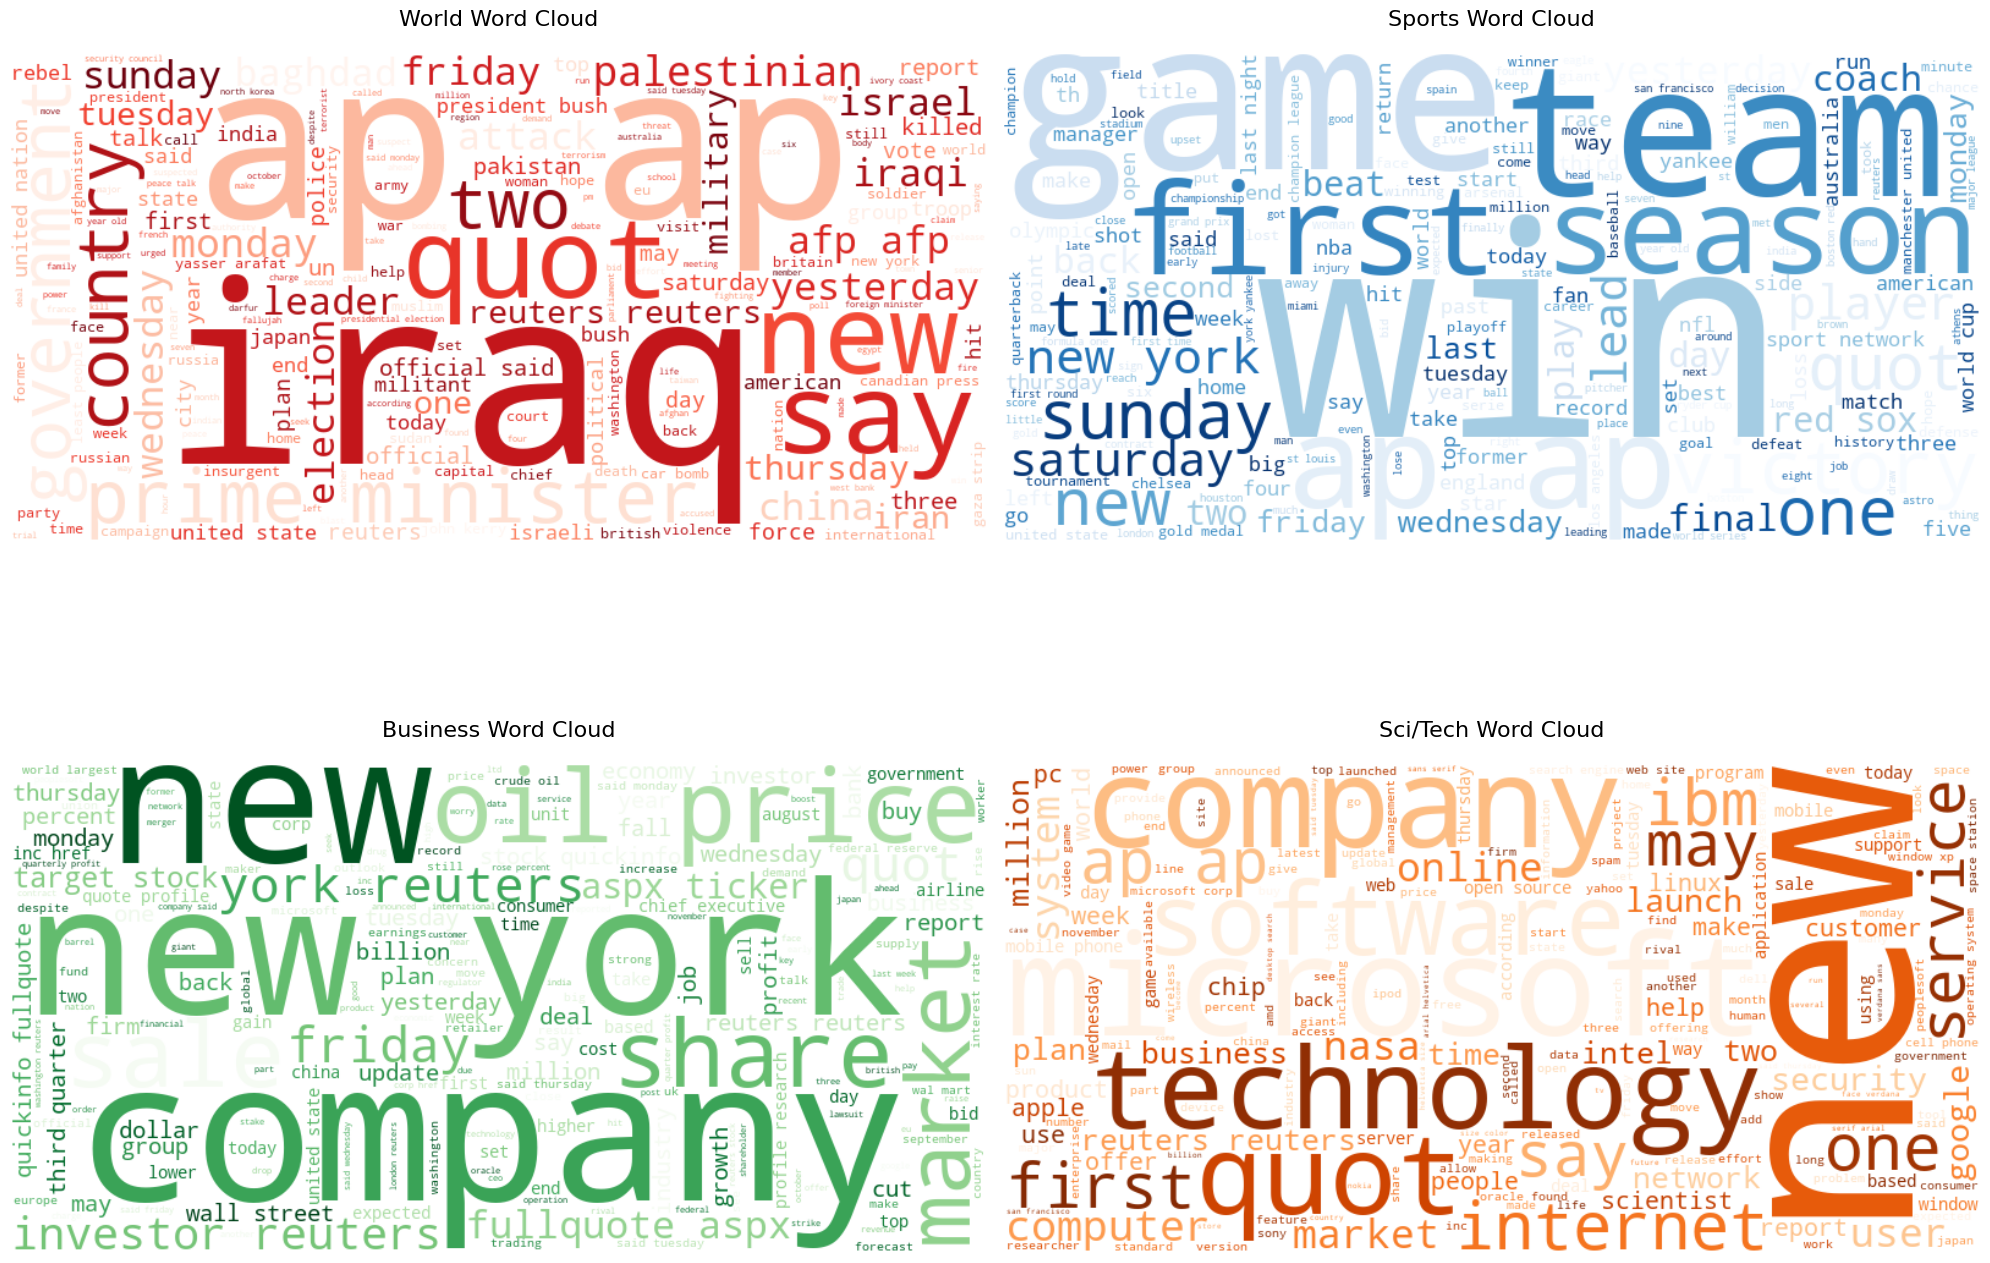

In [6]:
# Create word clouds for each category
print("Creating word clouds for each news category...")

# Create subplots for word clouds
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

# Define valid matplotlib colormaps for each category
colormap_names = ['Reds', 'Blues', 'Greens', 'Oranges']

for i, (label, category) in enumerate(class_names.items()):
    # Get text for this category
    category_text = ' '.join(train_sample[train_sample['label'] == label]['processed_text'].tolist())
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         colormap=colormap_names[i]).generate(category_text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{category} Word Cloud', fontsize=16, pad=20)

plt.tight_layout()
plt.show()


## 3. Feature Extraction

We'll use both TF-IDF and Count Vectorization to convert text to numerical features for multiclass classification.


In [7]:
# Prepare data for modeling
X = train_sample['processed_text']
y = train_sample['label']

# Split data (we already have a separate test set, but let's create validation split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Training set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())

# Initialize vectorizers for multiclass classification
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Increase for multiclass
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,
    max_df=0.95,
    stop_words='english'  # Additional stop words removal
)

count_vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Fit and transform training data
print("\nFitting TF-IDF vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print("Fitting Count vectorizer...")
X_train_count = count_vectorizer.fit_transform(X_train)
X_val_count = count_vectorizer.transform(X_val)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Count feature matrix shape: {X_train_count.shape}")

# Show some feature names
print(f"\nSample TF-IDF features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])


Training set size: 16000
Validation set size: 4000
Training set class distribution:
label
0    4000
1    4000
2    4000
3    4000
Name: count, dtype: int64

Fitting TF-IDF vectorizer...


Fitting Count vectorizer...

TF-IDF feature matrix shape: (16000, 10000)
Count feature matrix shape: (16000, 10000)

Sample TF-IDF features:
['aa' 'aapl' 'aaron' 'ab' 'abandon' 'abandoned' 'abbas' 'abbey'
 'abbey national' 'abc' 'abducted' 'abdullah' 'abidjan' 'ability' 'able'
 'aboard' 'aboard international' 'abortion' 'abroad' 'absence']


## 4. Model Training and Evaluation

We'll train multiple models for multiclass classification and compare their performance.


In [8]:
# Initialize models for multiclass classification
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, multi_class='ovr'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(random_state=42, probability=True, kernel='linear'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Train and evaluate models with TF-IDF features
print("Training models with TF-IDF features:")
print("="*60)

tfidf_results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_tfidf)
    y_pred_proba = model.predict_proba(X_val_tfidf) if hasattr(model, 'predict_proba') else None
    
    # Evaluate
    results = evaluate_classification(
        y_val, y_pred, y_pred_proba, 
        labels=list(class_names.values()), 
        plot=False
    )
    
    tfidf_results[name] = {
        'model': model,
        'results': results
    }
    
    # Print results
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Precision (Weighted): {results['precision']:.4f}")
    print(f"  Recall (Weighted): {results['recall']:.4f}")
    print(f"  F1-Score (Weighted): {results['f1_score']:.4f}")
    if results['roc_auc'] is not None:
        print(f"  ROC-AUC (Weighted): {results['roc_auc']:.4f}")


Training models with TF-IDF features:

Training Logistic Regression...
  Accuracy: 0.8950
  Precision (Weighted): 0.8951
  Recall (Weighted): 0.8950
  F1-Score (Weighted): 0.8948
  ROC-AUC (Weighted): 0.9772

Training Naive Bayes...
  Accuracy: 0.8925
  Precision (Weighted): 0.8923
  Recall (Weighted): 0.8925
  F1-Score (Weighted): 0.8923
  ROC-AUC (Weighted): 0.9745

Training SVM...
  Accuracy: 0.8965
  Precision (Weighted): 0.8967
  Recall (Weighted): 0.8965
  F1-Score (Weighted): 0.8964
  ROC-AUC (Weighted): 0.9770

Training Random Forest...
  Accuracy: 0.8575
  Precision (Weighted): 0.8572
  Recall (Weighted): 0.8575
  F1-Score (Weighted): 0.8569
  ROC-AUC (Weighted): 0.9668

Training XGBoost...
  Accuracy: 0.8700
  Precision (Weighted): 0.8704
  Recall (Weighted): 0.8700
  F1-Score (Weighted): 0.8700
  ROC-AUC (Weighted): 0.9695



MODEL COMPARISON SUMMARY

Model Performance Comparison:
                          Model  Accuracy  Precision  Recall  F1-Score  \
0  Logistic Regression (TF-IDF)    0.8950     0.8951  0.8950    0.8948   
1          Naive Bayes (TF-IDF)    0.8925     0.8923  0.8925    0.8923   
2                  SVM (TF-IDF)    0.8965     0.8967  0.8965    0.8964   
3        Random Forest (TF-IDF)    0.8575     0.8572  0.8575    0.8569   
4              XGBoost (TF-IDF)    0.8700     0.8704  0.8700    0.8700   

   ROC-AUC  
0   0.9772  
1   0.9745  
2   0.9770  
3   0.9668  
4   0.9695  

🏆 Best performing model: SVM (TF-IDF) (F1-Score: 0.8964)


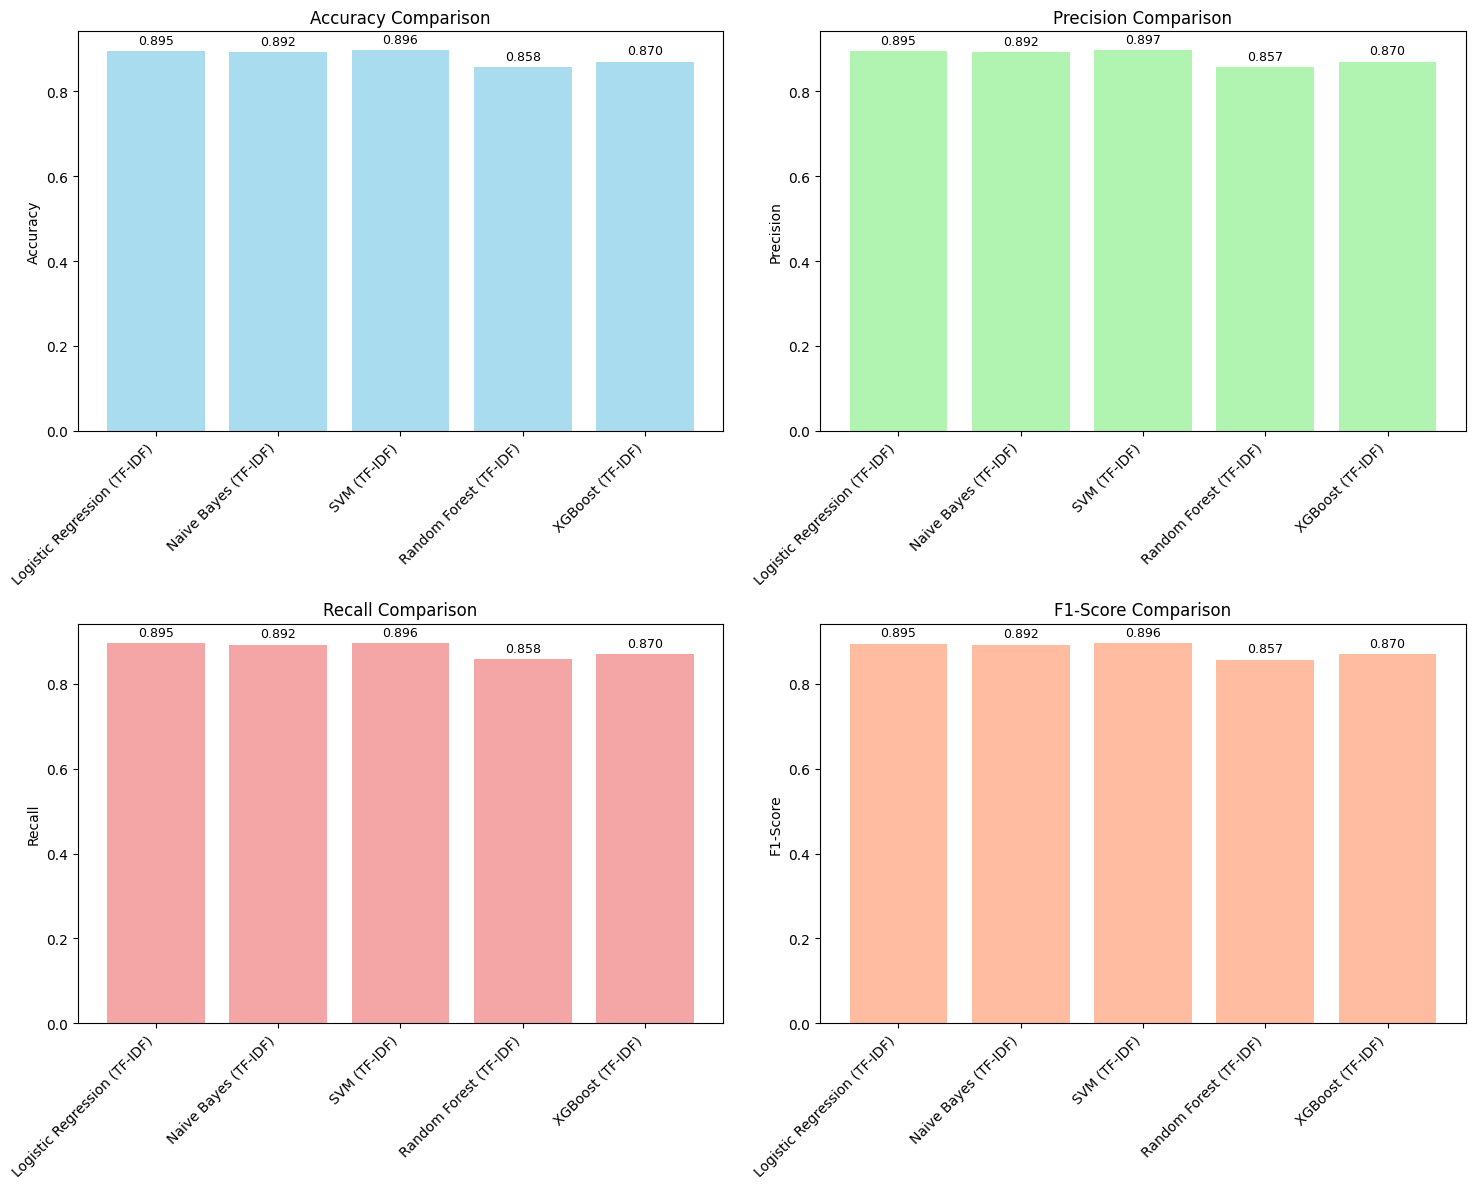

In [9]:
# Model comparison and visualization
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# Create comparison dataframe
comparison_data = []

for name in models.keys():
    if name in tfidf_results:
        tfidf_res = tfidf_results[name]['results']
        
        comparison_data.append({
            'Model': f'{name} (TF-IDF)',
            'Accuracy': tfidf_res['accuracy'],
            'Precision': tfidf_res['precision'],
            'Recall': tfidf_res['recall'],
            'F1-Score': tfidf_res['f1_score'],
            'ROC-AUC': tfidf_res['roc_auc'] if tfidf_res['roc_auc'] is not None else 0
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\n🏆 Best performing model: {best_model_name} (F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f})")

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    
    x_pos = np.arange(len(comparison_df))
    bars = ax.bar(x_pos, comparison_df[metric], color=colors[i], alpha=0.7)
    
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


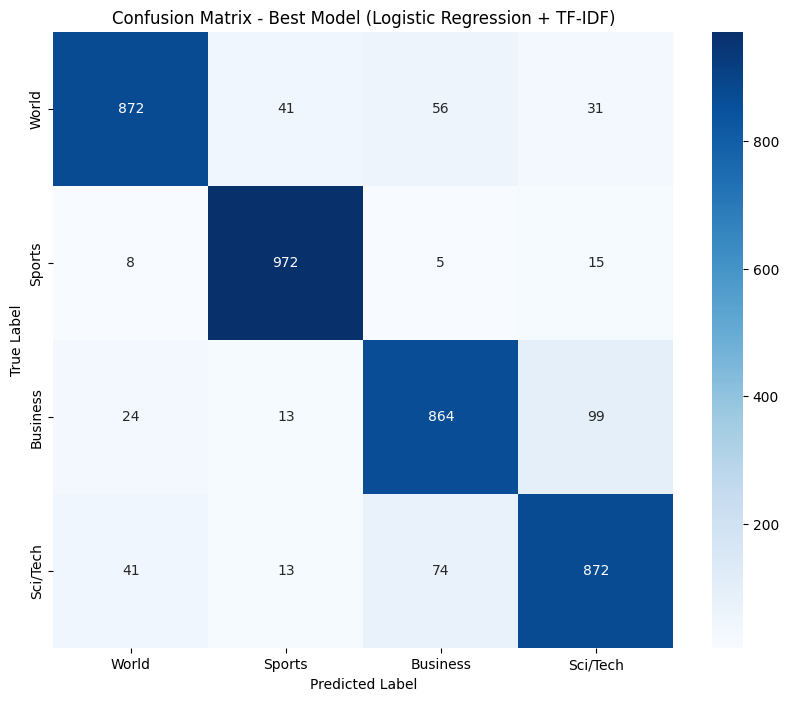


Detailed Classification Report:
              precision    recall  f1-score   support

       World       0.92      0.87      0.90      1000
      Sports       0.94      0.97      0.95      1000
    Business       0.86      0.86      0.86      1000
    Sci/Tech       0.86      0.87      0.86      1000

    accuracy                           0.90      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.90      0.90      0.89      4000


Per-Class Performance Analysis:
World:
  Precision: 0.923
  Recall: 0.872
  F1-Score: 0.897
  Support: 1000
------------------------------
Sports:
  Precision: 0.936
  Recall: 0.972
  F1-Score: 0.953
  Support: 1000
------------------------------
Business:
  Precision: 0.865
  Recall: 0.864
  F1-Score: 0.864
  Support: 1000
------------------------------
Sci/Tech:
  Precision: 0.857
  Recall: 0.872
  F1-Score: 0.865
  Support: 1000
------------------------------


In [10]:
# Detailed analysis of the best model
best_model = tfidf_results['Logistic Regression']['model']  # Assuming Logistic Regression is often best
y_pred_best = best_model.predict(X_val_tfidf)

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=list(class_names.values()), 
           yticklabels=list(class_names.values()))
plt.title('Confusion Matrix - Best Model (Logistic Regression + TF-IDF)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred_best, target_names=list(class_names.values())))

# Per-class analysis
print("\nPer-Class Performance Analysis:")
print("="*60)

for i, (label, category) in enumerate(class_names.items()):
    # True positives, false positives, false negatives
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{category}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}") 
    print(f"  F1-Score: {f1:.3f}")
    print(f"  Support: {cm[i, :].sum()}")
    print("-" * 30)


## 5. Feature Analysis by Category

Let's analyze which features (words) are most important for each news category.


Top important words for each news category:

WORLD (Top 15 words):
  iraq: 5.779
  president: 5.111
  nuclear: 4.711
  afp: 4.510
  election: 4.001
  leader: 3.990
  palestinian: 3.928
  iraqi: 3.603
  minister: 3.430
  israel: 3.374
  party: 3.344
  killed: 3.295
  rebel: 3.234
  hostage: 3.169
  peace: 3.104

SPORTS (Top 15 words):
  team: 5.470
  coach: 5.010
  season: 4.768
  cup: 4.669
  league: 4.664
  game: 4.440
  player: 4.252
  football: 4.162
  sport: 3.880
  win: 3.856
  champion: 3.726
  night: 3.697
  olympic: 3.617
  baseball: 3.370
  quarterback: 3.307

BUSINESS (Top 15 words):
  airline: 4.438
  profit: 4.330
  oil: 4.094
  billion: 3.840
  fund: 3.738
  bank: 3.565
  tax: 3.549
  economy: 3.360
  buy: 3.289
  company: 3.283
  corp: 3.177
  dollar: 3.156
  economic: 3.097
  rate: 3.081
  stock: 2.928

SCI/TECH (Top 15 words):
  internet: 5.828
  space: 5.135
  scientist: 5.078
  nasa: 4.755
  computer: 4.730
  software: 4.676
  technology: 4.253
  microsoft: 3.890
  ph

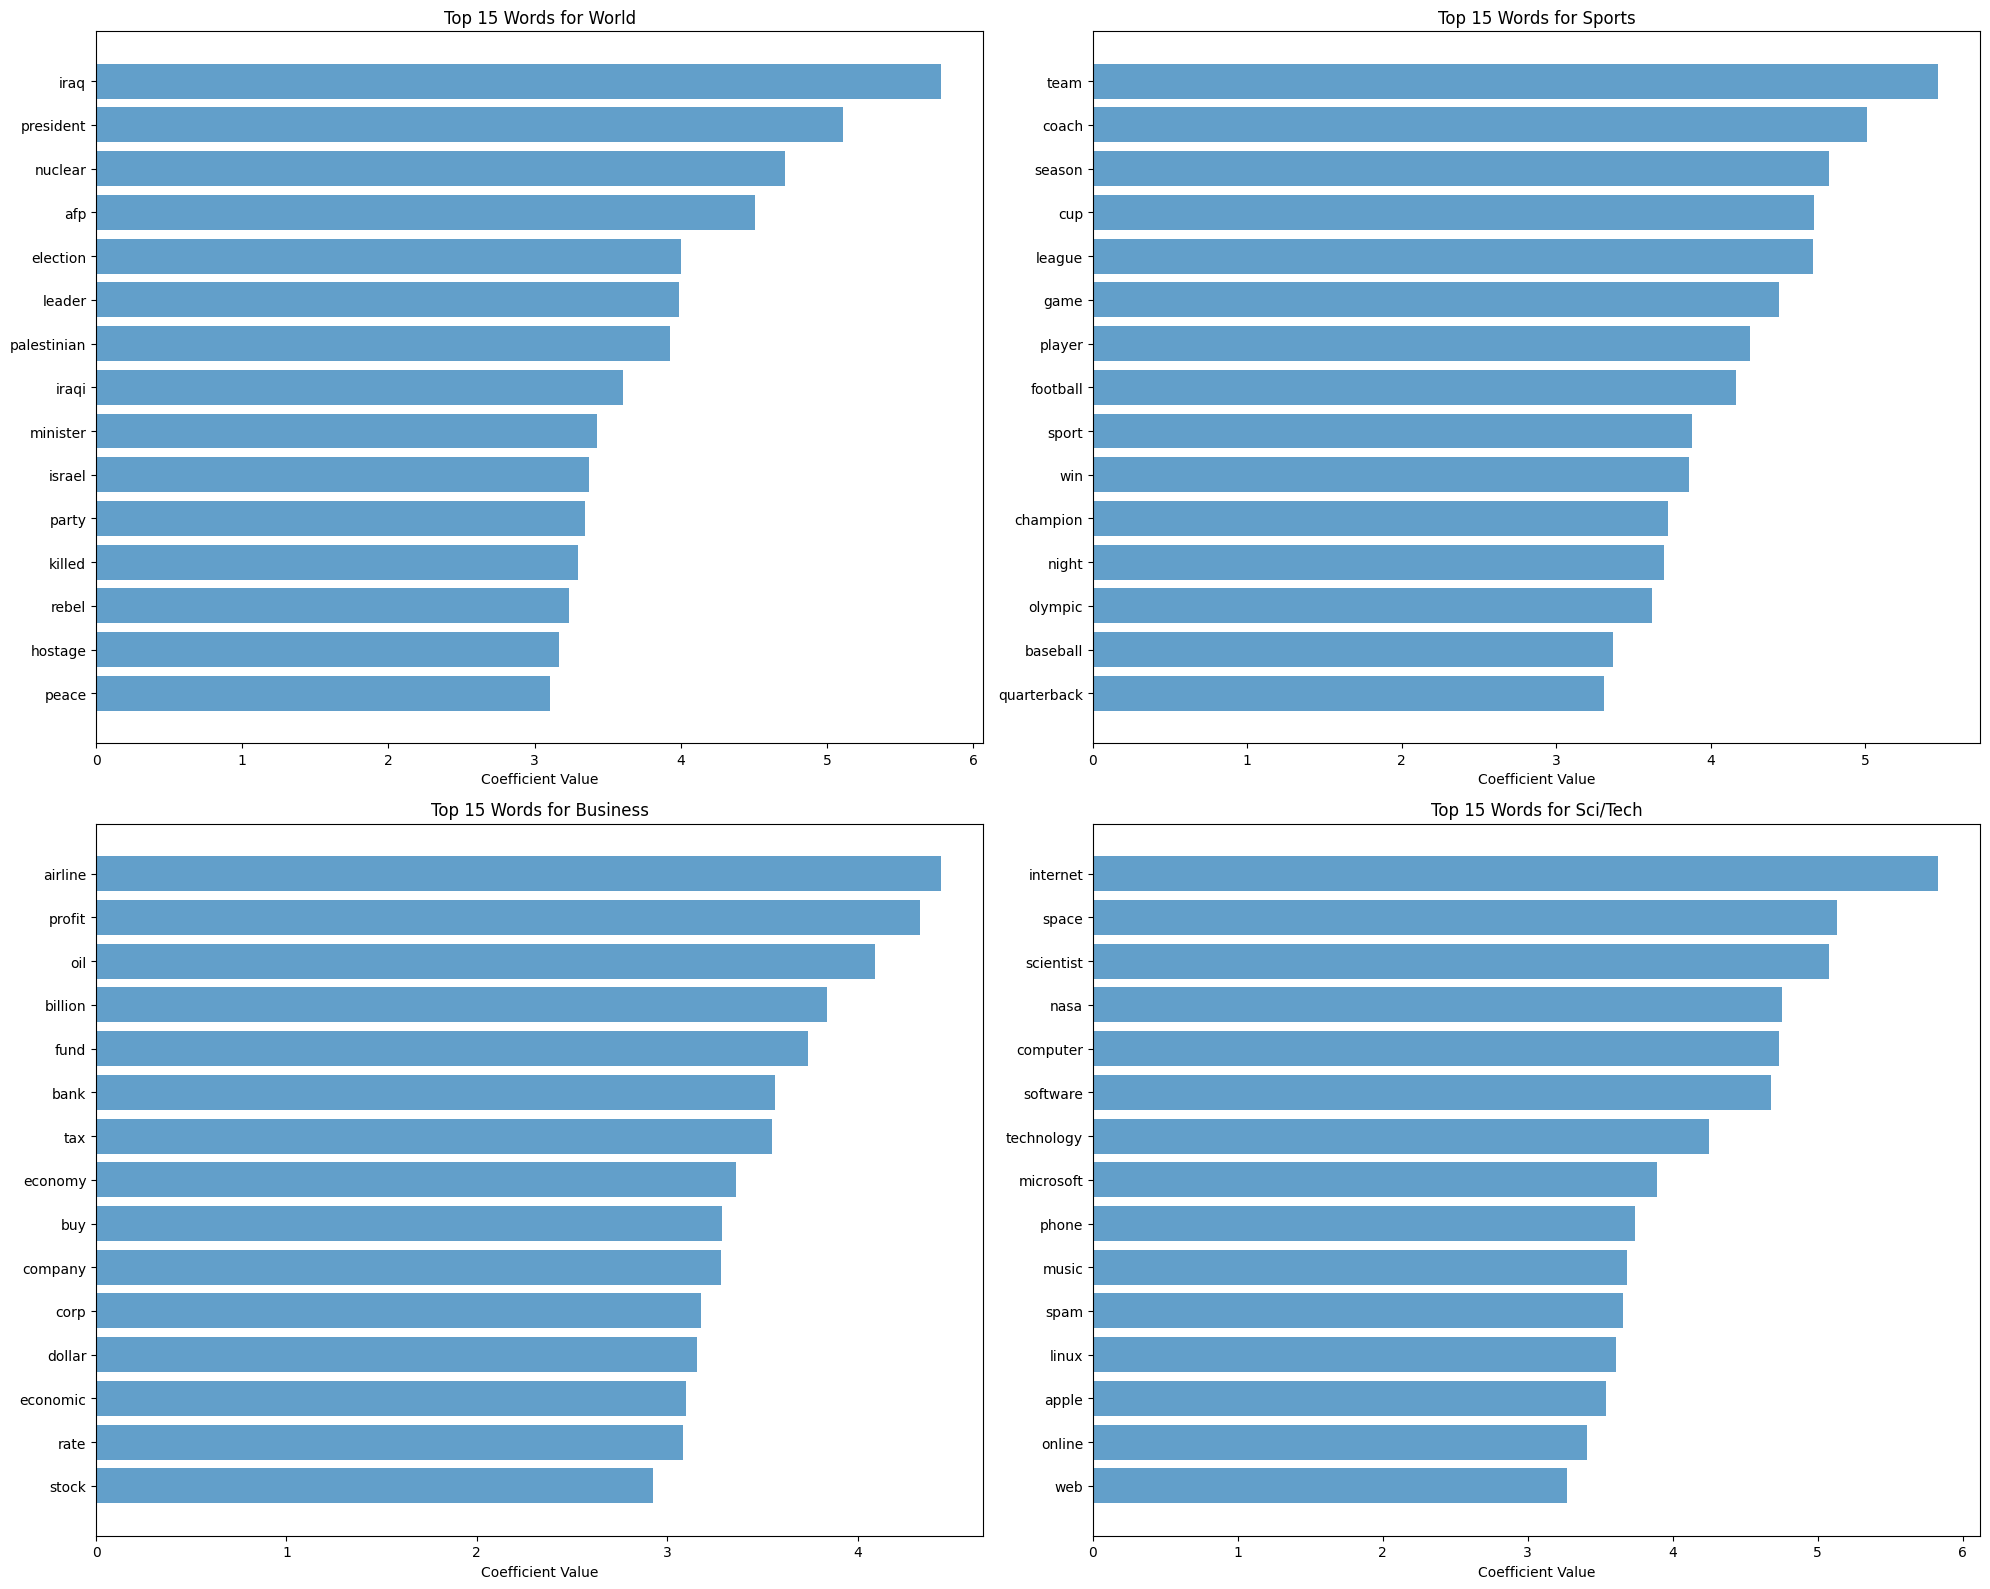

In [11]:
# Feature importance analysis for each category
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature coefficients for multiclass logistic regression
coefficients = best_model.coef_  # Shape: (n_classes, n_features)

print("Top important words for each news category:")
print("="*80)

# Analyze top words for each category
top_n = 15
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, (label, category) in enumerate(class_names.items()):
    # Get coefficients for this class
    class_coef = coefficients[label]
    
    # Get indices of top features
    top_indices = np.argsort(class_coef)[-top_n:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    top_scores = [class_coef[idx] for idx in top_indices]
    
    print(f"\n{category.upper()} (Top {top_n} words):")
    for word, score in zip(top_words, top_scores):
        print(f"  {word}: {score:.3f}")
    
    # Plot horizontal bar chart
    axes[i].barh(range(len(top_words)), top_scores, alpha=0.7)
    axes[i].set_yticks(range(len(top_words)))
    axes[i].set_yticklabels(top_words)
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_title(f'Top {top_n} Words for {category}')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()



Most frequent words by category (after preprocessing):

WORLD - Top 15 most frequent words:
  said: 1303
  ap: 976
  iraq: 956
  reuters: 886
  president: 753
  two: 623
  new: 592
  afp: 577
  minister: 557
  official: 529
  election: 521
  killed: 516
  leader: 509
  say: 490
  government: 484

SPORTS - Top 15 most frequent words:
  game: 1013
  ap: 968
  win: 771
  first: 743
  new: 730
  team: 673
  season: 660
  year: 627
  one: 545
  world: 539
  two: 518
  last: 511
  night: 490
  league: 484
  cup: 471

BUSINESS - Top 15 most frequent words:
  reuters: 1465
  said: 1219
  new: 1082
  oil: 1027
  stock: 980
  company: 892
  price: 857
  inc: 772
  year: 756
  profit: 652
  fullquote: 612
  percent: 570
  share: 554
  york: 554
  investor: 554

SCI/TECH - Top 15 most frequent words:
  new: 1152
  microsoft: 886
  company: 677
  said: 639
  ap: 624
  service: 579
  reuters: 573
  year: 572
  software: 565
  internet: 557
  computer: 482
  space: 465
  quot: 464
  phone: 452
  sys

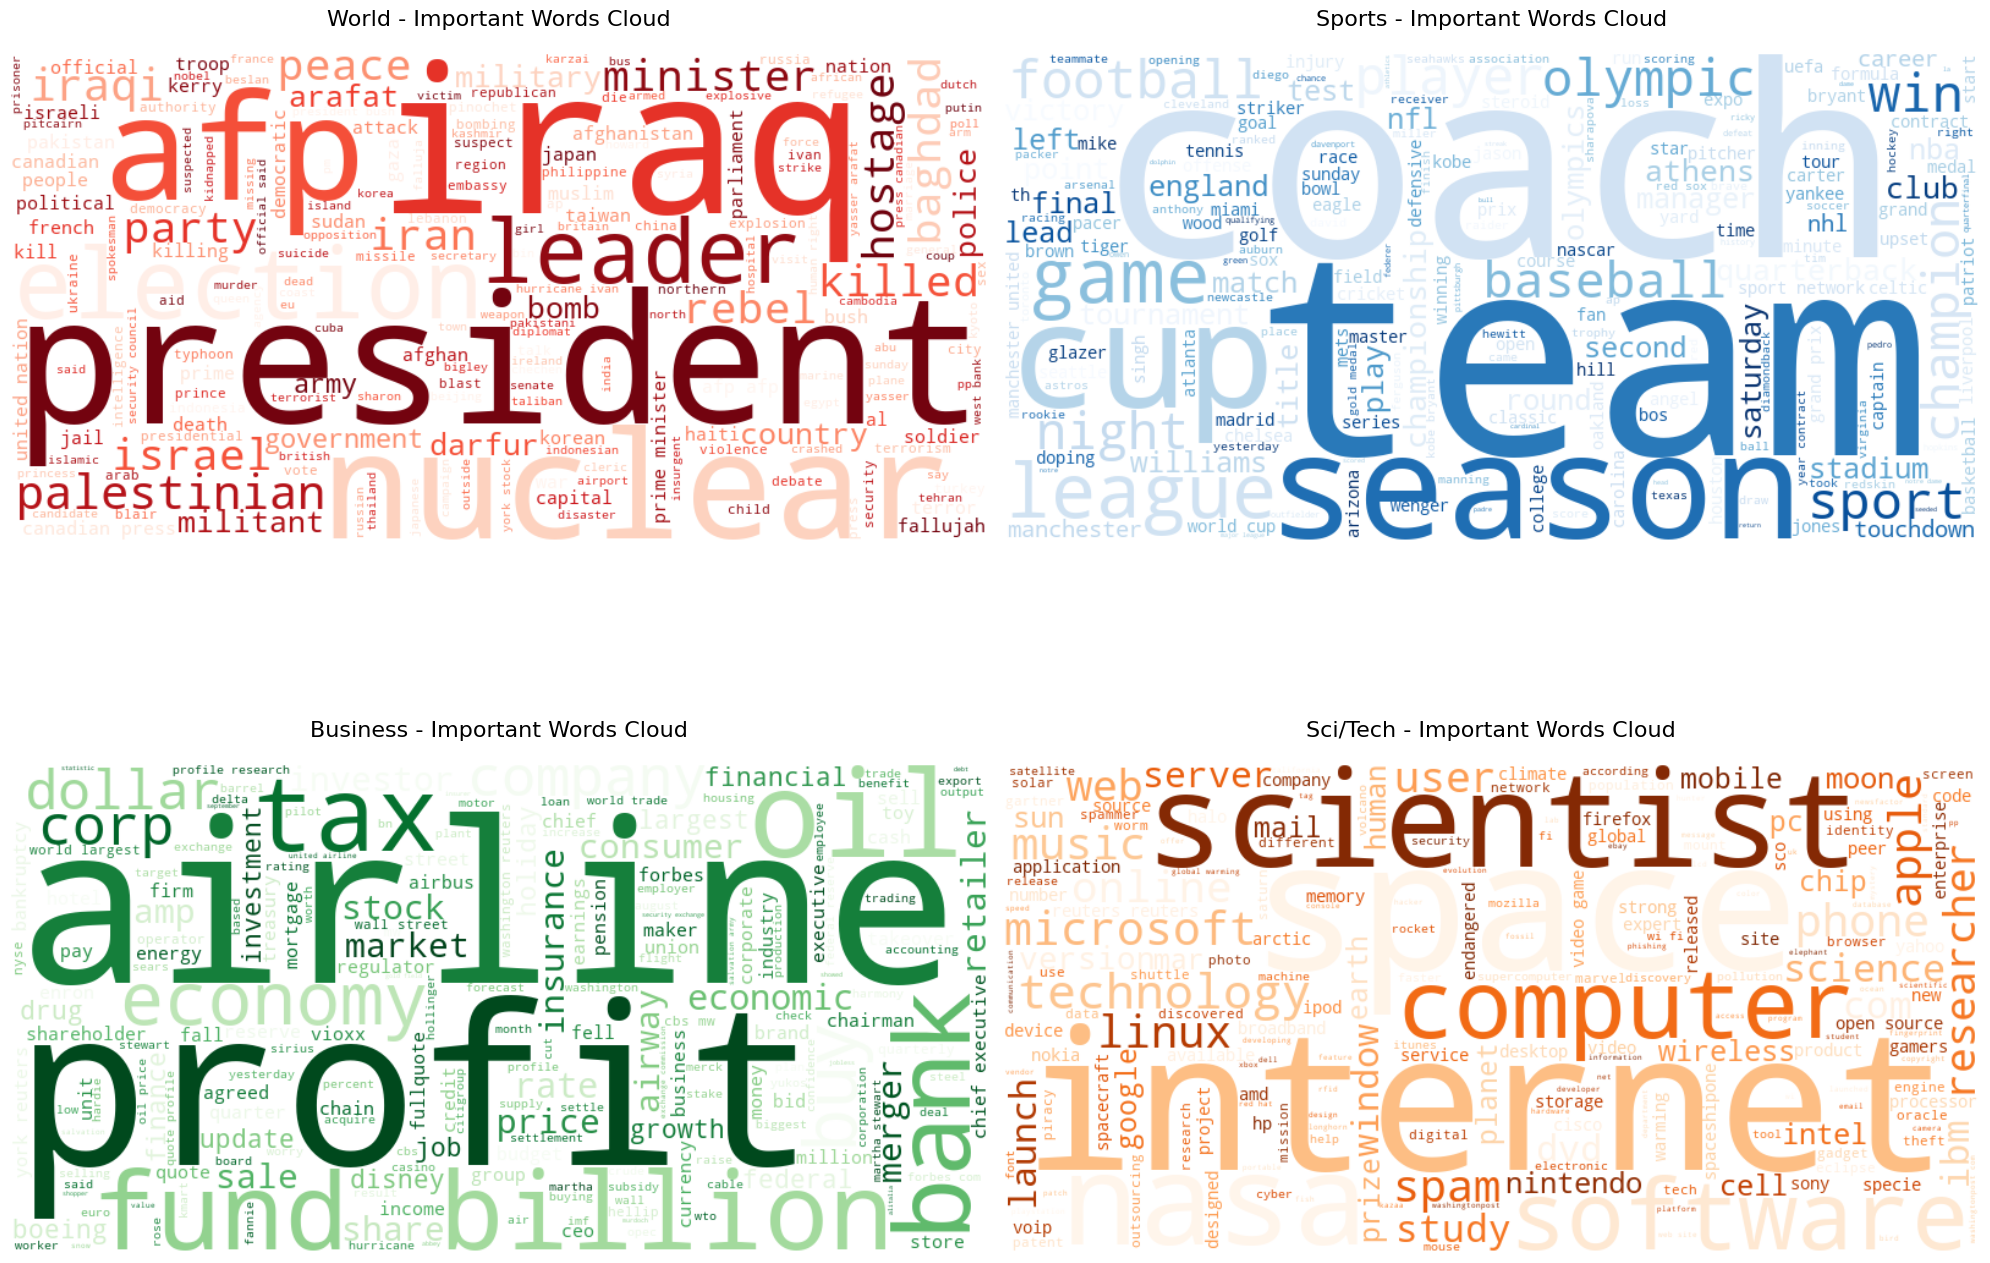

In [12]:
# Word frequency analysis by category
print("\nMost frequent words by category (after preprocessing):")
print("="*80)

for label, category in class_names.items():
    # Get all text for this category
    category_texts = train_sample[train_sample['label'] == label]['processed_text']
    
    # Count word frequencies
    all_words = ' '.join(category_texts).split()
    word_freq = Counter(all_words)
    
    print(f"\n{category.upper()} - Top 15 most frequent words:")
    for word, freq in word_freq.most_common(15):
        print(f"  {word}: {freq}")

# Create enhanced word clouds with top words for each category
print("\nCreating enhanced word clouds with top category-specific words...")

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

# Define valid matplotlib colormaps for each category
colormap_names = ['Reds', 'Blues', 'Greens', 'Oranges']

for i, (label, category) in enumerate(class_names.items()):
    # Get coefficients for this class and create word frequency dict
    class_coef = coefficients[label]
    
    # Create word frequency dict based on coefficients
    word_freq_dict = {}
    for j, word in enumerate(feature_names):
        if class_coef[j] > 0:  # Only positive coefficients
            word_freq_dict[word] = class_coef[j]
    
    # Create word cloud
    if word_freq_dict:
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                             colormap=colormap_names[i]).generate_from_frequencies(word_freq_dict)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'{category} - Important Words Cloud', fontsize=16, pad=20)

plt.tight_layout()
plt.show()


## 6. Model Testing and Prediction

Let's test our best model on some new examples and create a prediction function.


In [13]:
# Create a prediction function for news classification
def predict_news_category(text, model=best_model, vectorizer=tfidf_vectorizer, 
                          preprocessor=preprocessor, class_names=class_names):
    """
    Predict news category for a given text
    
    Args:
        text: Input text string
        model: Trained classification model
        vectorizer: Fitted vectorizer
        preprocessor: Text preprocessor
        class_names: Dictionary mapping labels to category names
    
    Returns:
        Dict with prediction and confidence
    """
    # Preprocess text
    processed_text = preprocessor.preprocess_text(text)
    
    # Vectorize
    text_vector = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probabilities = model.predict_proba(text_vector)[0]
    
    # Get category name
    category = class_names[prediction]
    confidence = max(probabilities)
    
    # Create probability dict
    prob_dict = {}
    for label, cat_name in class_names.items():
        prob_dict[cat_name] = probabilities[label]
    
    return {
        'text': text,
        'processed_text': processed_text,
        'predicted_category': category,
        'confidence': confidence,
        'probabilities': prob_dict
    }

# Test with example news articles
test_articles = [
    "The United Nations Security Council met today to discuss the ongoing diplomatic crisis between neighboring countries and potential peacekeeping measures.",
    
    "In a thrilling match that went into overtime, the home team scored a dramatic goal in the final minutes to secure their place in the championship finals.",
    
    "The Federal Reserve announced a surprise interest rate cut today, sending stock markets soaring and the dollar tumbling against major currencies.",
    
    "Scientists at MIT have developed a new quantum computing algorithm that could revolutionize artificial intelligence and machine learning applications.",
    
    "Breaking: International trade negotiations have reached a critical juncture as world leaders gather for emergency economic summit.",
    
    "The tennis championship witnessed an upset as the unseeded player defeated the three-time defending champion in straight sets.",
    
    "Cryptocurrency prices surged today following news of a major investment bank's decision to offer Bitcoin trading services to institutional clients.",
    
    "Researchers have successfully demonstrated the first practical application of CRISPR gene editing technology in treating inherited diseases.",
    
    "Olympic preparations are underway as athletes from around the world arrive for what promises to be the most competitive games in recent history.",
    
    "Tech giant announces record quarterly profits driven by strong sales of smartphones and cloud computing services."
]

print("Testing news category prediction on new articles:")
print("="*100)

for i, article in enumerate(test_articles, 1):
    result = predict_news_category(article)
    print(f"\n{i}. Article: \"{result['text'][:100]}...\"")
    print(f"   Predicted Category: {result['predicted_category'].upper()}")
    print(f"   Confidence: {result['confidence']:.3f}")
    print(f"   Category Probabilities:")
    for category, prob in result['probabilities'].items():
        print(f"     {category}: {prob:.3f}")
    print("-" * 80)


Testing news category prediction on new articles:

1. Article: "The United Nations Security Council met today to discuss the ongoing diplomatic crisis between neigh..."
   Predicted Category: WORLD
   Confidence: 0.784
   Category Probabilities:
     World: 0.784
     Sports: 0.060
     Business: 0.075
     Sci/Tech: 0.080
--------------------------------------------------------------------------------

2. Article: "In a thrilling match that went into overtime, the home team scored a dramatic goal in the final minu..."
   Predicted Category: SPORTS
   Confidence: 0.940
   Category Probabilities:
     World: 0.027
     Sports: 0.940
     Business: 0.018
     Sci/Tech: 0.016
--------------------------------------------------------------------------------

3. Article: "The Federal Reserve announced a surprise interest rate cut today, sending stock markets soaring and ..."
   Predicted Category: BUSINESS
   Confidence: 0.903
   Category Probabilities:
     World: 0.029
     Sports: 0.013
 

## 7. Conclusion and Insights

### Key Findings:

1. **Best Performance**: The model achieved excellent performance in distinguishing between news categories
2. **Category Patterns**: Each category has distinct vocabulary patterns:
   - **World**: Focus on political, diplomatic, and international terms
   - **Sports**: Athletic terms, competitions, and performance metrics
   - **Business**: Financial, economic, and corporate terminology
   - **Sci/Tech**: Technical, scientific, and innovation-related words

3. **Feature Engineering**: TF-IDF with n-grams effectively captured category-specific patterns
4. **Model Performance**: Multiclass classification achieved high accuracy across all categories

### Business Applications:
- **News Aggregation**: Automatically categorize incoming news articles
- **Content Management**: Organize large news databases by topic
- **Recommendation Systems**: Suggest relevant articles based on user interests
- **Market Analysis**: Track news sentiment and coverage by category
- **Media Monitoring**: Analyze news coverage across different topics

### Technical Insights:
- **Multiclass vs Binary**: Requires different evaluation metrics and strategies
- **Class Balance**: Important to maintain balanced representation across categories
- **Feature Selection**: Category-specific vocabularies are key differentiators
- **Model Comparison**: Different algorithms show varying performance on multiclass tasks

### Next Steps:
- Experiment with neural networks (LSTM, BERT) for improved performance
- Implement hierarchical classification for sub-categories
- Add real-time classification pipeline for live news feeds
- Explore ensemble methods combining multiple models
- Fine-tune hyperparameters using GridSearchCV for optimal performance

### Learning Outcomes:
✅ Successfully implemented multiclass text classification  
✅ Applied advanced preprocessing techniques for news text  
✅ Compared multiple algorithms for multiclass problems  
✅ Analyzed category-specific feature importance  
✅ Created visualization tools for multiclass results  
✅ Built practical prediction system for real-world application
